Streaming output truncated to the last 5000 lines.
Segment 2: Count = 379, Area = 3069, Ratio = 0.12
Segment 3: Count = 0, Area = 3520, Ratio = 0.00
Segment 4: Count = 546, Area = 3080, Ratio = 0.18
Segment 5: Count = 296, Area = 3520, Ratio = 0.08
Segment 6: Count = 239, Area = 3080, Ratio = 0.08
Flags: []
Segment 0: Count = 189, Area = 2380, Ratio = 0.08
Segment 1: Count = 0, Area = 726, Ratio = 0.00
Segment 2: Count = 0, Area = 3069, Ratio = 0.00
Segment 3: Count = 0, Area = 3520, Ratio = 0.00
Segment 4: Count = 0, Area = 3080, Ratio = 0.00
Segment 5: Count = 94, Area = 3520, Ratio = 0.03
Segment 6: Count = 0, Area = 3080, Ratio = 0.00
Flags: []
Segment 0: Count = 443, Area = 2380, Ratio = 0.19
Segment 1: Count = 37, Area = 726, Ratio = 0.05
Segment 2: Count = 0, Area = 3069, Ratio = 0.00
Segment 3: Count = 409, Area = 3520, Ratio = 0.12
Segment 4: Count = 3, Area = 3080, Ratio = 0.00
Segment 5: Count = 660, Area = 3520, Ratio = 0.19
Segment 6: Count = 623, Area = 3080, Ratio = 0.20

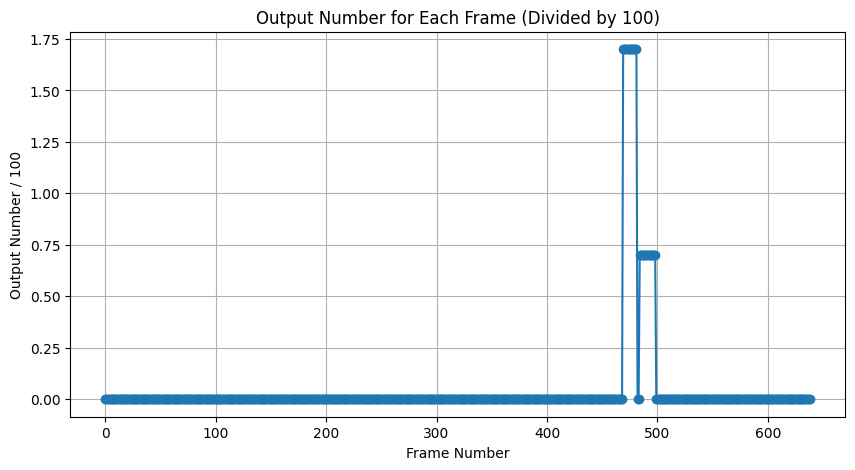

In [1]:
import cv2
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

class Segments:
    def __init__(self):
        self.flags = []
        self.segments = self.create_segments()

    def create_segments(self):
        segments = [
            [[0.25, 0.9], [0.025, 0.15]],
            [[0.4, 0.65], [0.45, 0.55]],
            [[0.15, 0.85], [0.85, 1]],
            [[0.15, 0.45], [0.05, 0.45]],
            [[0.125, 0.425], [0.55, .9]],
            [[0.7, 1], [0.05, 0.45]],
            [[0.65, 0.95], [0.5, .85]]
        ]
        return segments

    def digest(self, number, segment_threshold):
        self.flags = []
        h, w = number.shape[:2]
        for a in range(len(self.segments)):
            seg = self.segments[a]
            xl, xh = seg[0]
            yl, yh = seg[1]
            xl = int(xl * w)
            xh = int(xh * w)
            yl = int(yl * h)
            yh = int(yh * h)
            sw = xh - xl
            sh = yh - yl
            if sw == 0 or sh == 0:
                continue
            count = np.count_nonzero(number[yl:yh, xl:xh] == 255)
            if count / (sh * sw) > segment_threshold:
                self.flags.append(a)
            print(f"Segment {a}: Count = {count}, Area = {sh * sw}, Ratio = {count / (sh * sw):.2f}")
            cv2.rectangle(number, (xl, yl), (xh, yh), (128, 128, 128), 1)

    def getNum(self):
        print(f"Flags: {self.flags}")
        if self.flags == [0, 2, 3, 4, 5, 6]:
            return 0
        if self.flags == [5, 6]:
            return 1
        if self.flags == [0, 1, 2, 4, 5]:
            return 2
        if self.flags == [0, 1, 2, 5, 6]:
            return 3
        if self.flags == [1, 3, 5, 6]:
            return 4
        if self.flags == [0, 1, 2, 3, 6]:
            return 5
        if self.flags == [0, 1, 2, 3, 4, 6]:
            return 6
        if self.flags == [0, 5, 6]:
            return 7
        if self.flags == [0, 1, 2, 3, 4, 5, 6]:
            return 8
        if self.flags == [0, 1, 2, 3, 5, 6]:
            return 9
        if self.flags == []:
            return 0
        return -1

def process_video(video_path, output_csv, output_dir, frame_skip, binary_threshold, segment_threshold):
    video_path = os.path.normpath(video_path.replace('"', ''))
    output_csv = os.path.normpath(output_csv.replace('"', ''))
    output_dir = os.path.normpath(output_dir.replace('"', ''))

    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_list = []
    frame_numbers = []
    model = Segments()

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for i in range(0, frame_count, frame_skip):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if not ret:
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        _, binary = cv2.threshold(gray, binary_threshold, 255, cv2.THRESH_BINARY_INV)
        height, width = binary.shape
        segment_width = width // 4
        segments = [binary[:, j*segment_width:(j+1)*segment_width] for j in range(4)]
        detected_numbers = []

        for j, segment in enumerate(segments):
            segment_copy = segment.copy()
            model.digest(segment_copy, segment_threshold)
            number = model.getNum()
            detected_numbers.append(number if number != -1 else '_')

            # Annotate the segment with the detected number
            cv2.putText(segment_copy, str(number), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

            # Save the annotated segment
            annotated_segment_path = os.path.join(output_dir, f"frame_{i:04d}_segment_{j}.png")
            cv2.imwrite(annotated_segment_path, segment_copy)

        combined_result = ''.join(map(str, detected_numbers))
        frame_list.append(int(combined_result) / 100 if combined_result.isdigit() else 0)
        frame_numbers.append(i)

    cap.release()
    cv2.destroyAllWindows()

    df = pd.DataFrame(list(enumerate(frame_list, start=1)), columns=['Frame Number', 'Detected Numbers'])
    df.to_csv(output_csv, index=False)
    print(f"Output saved to {output_csv}")

    # Plotting output number for each frame against the frame number
    plt.figure(figsize=(10, 5))
    plt.plot(frame_numbers, frame_list, marker='o')
    plt.xlabel('Frame Number')
    plt.ylabel('Output Number / 100')
    plt.title('Output Number for Each Frame (Divided by 100)')
    plt.grid(True)

    # Save the plot as a PNG file to a specific path
    plot_output_path = os.path.join(output_dir, "output_plot.png")
    plt.savefig(plot_output_path)
    print(f"Plot saved to {plot_output_path}")

    #plt.show()

def process_multiple_videos(video_paths, output_dir_base, frame_skip, binary_threshold, segment_threshold):
    output_dir_base = os.path.normpath(output_dir_base.replace('"', ''))
    for video_path in video_paths:
        video_path = os.path.normpath(video_path.replace('"', ''))
        base_filename = os.path.splitext(os.path.basename(video_path))[0]
        output_csv = os.path.join(output_dir_base, f"output_data_{base_filename}.csv")
        output_dir = os.path.join(output_dir_base, f"processed_frames_{base_filename}")
        process_video(video_path, output_csv, output_dir, frame_skip, binary_threshold, segment_threshold)

def get_int_input(prompt):
    while True:
        try:
            return int(input(prompt))
        except ValueError:
            print("Please enter a valid integer.")

def get_float_input(prompt):
    while True:
        try:
            return float(input(prompt))
        except ValueError:
            print("Please enter a valid float.")

# Example usage
video_paths = input("Enter video paths separated by spaces: ").split()
output_dir_base = os.path.normpath(input("Enter the base output directory: ").replace('"', ''))

frame_skip = get_int_input("Skip every X frames: ")
binary_threshold = get_int_input("Image processing threshold (default is 75): ")
segment_threshold = get_float_input("Segment recognition threshold (default is 0.2): ")

process_multiple_videos(video_paths, output_dir_base, frame_skip, binary_threshold, segment_threshold)
